<a href="https://colab.research.google.com/github/gargarushee/multiAgentHandsOnExcerciseTechFutures/blob/main/MultiAgentSupervisorResearchAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SECTION 1: SETUP AND INSTALLATION
# ============================================================================

# Install required packages
!pip install langgraph
!pip install langsmith
!pip install langchain-openai
!pip install langgraph_supervisor
!pip install python-dotenv
!pip install langchain_google_genai

https://github.com/gargarushee/multiAgentHandsOnExcerciseTechFutures

Setup API KEYS!!

1. OPENAI_API_KEY https://platform.openai.com/api-keys
2. TAVILY_SEARCH Sign up at https://www.tavily.com/ to get API KEY access for web search

In [ ]:
# Set your API keys here
OPENAI_API_KEY = ""
TAVILY_API_KEY = ""
LANGSMITH_API_KEY = ""

In [ ]:
import os

# IPython display components for visualization
from IPython.display import Image, display

In [ ]:
# =============================================================================
# ENVIRONMENT SETUP
# =============================================================================

def _set_env(var: str, value: str) -> None:
  os.environ[var] = value

# Set API keys from the variables defined earlier
_set_env("OPENAI_API_KEY", OPENAI_API_KEY)
_set_env("LANGSMITH_API_KEY", LANGSMITH_API_KEY)
_set_env("TAVILY_API_KEY", TAVILY_API_KEY)


# Optional: Enable LangSmith tracing for observability
# This allows us to trace and debug our agent interactions
os.environ["LANGCHAIN_TRACING_V2"] = "true"

**Supervisor (tool-calling)¶**
In this variant of the supervisor architecture, we define a supervisor agent which is responsible for calling sub-agents. The sub-agents are exposed to the supervisor as tools, and the supervisor agent decides which tool to call next. The supervisor agent follows a standard implementation as an LLM running in a while loop calling tools until it decides to stop.

Lets create a demo Supervisor graph!!

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI()

def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_agent"])

def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()

🎨 Generating workflow diagram...


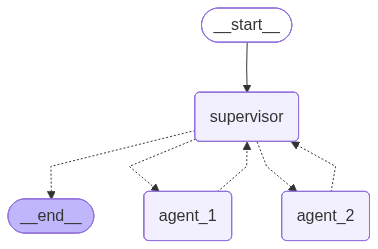

In [ ]:
# =============================================================================
# WORKFLOW VISUALIZATION
# =============================================================================

print("🎨 Generating workflow diagram...")
workflow_diagram = supervisor.get_graph().draw_mermaid_png()
display(Image(workflow_diagram))

## Lets Try it Yourself!!

Now lets add one more subagents to the graph and render the flow diagram.

Setup
First, let's install required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

1. Create worker agents

First, let's create our specialized worker agents — research agent and math agent:

Research agent will have access to a web search tool using Tavily API
Math agent will have access to simple math tools (add, multiply, divide)

Research agent
For web search, we will use TavilySearch tool from langchain-tavily:

In [ ]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

The current mayor isEric Adams, who was elected on November 2, 2021, and took office shortly after midnight on January 1, 2022.


To create individual worker agents, we will use LangGraph's prebuilt agent.

In [ ]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [ ]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

Let's run the agent
# Can run out of API credits so we have put the outputin next cell

In [ ]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Output:
Update from node agent:


================================== Ai Message =============================
Name: research_agent
Tool Calls:
  tavily_search (call_U748rQhQXT36sjhbkYLSXQtJ)
 Call ID: call_U748rQhQXT36sjhbkYLSXQtJ
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message=============================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "List of mayors of New York City - Wikipedia", "url": "https://en.wikipedia.org/wiki/List_of_mayors_of_New_York_City", "content": "The mayor of New York City is the chief executive of the Government of New York City, as stipulated by New York City's charter.The current officeholder, the 110th in the sequence of regular mayors, is Eric Adams, a member of the Democratic Party.. During the Dutch colonial period from 1624 to 1664, New Amsterdam was governed by the Director of Netherland.", "score": 0.9039154, "raw_content": null}, {"title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City's economy, reduce inequality, improve", "score": 0.8405867, "raw_content": null}, {"title": "Eric Adams - Wikipedia", "url": "https://en.wikipedia.org/wiki/Eric_Adams", "content": "Eric Leroy Adams (born September 1, 1960) is an American politician and former police officer who has served as the 110th mayor of New York City since 2022. Adams was an officer in the New York City Transit Police and then the New York City Police Department (```

Math agent¶
For math agent tools we will use vanilla Python functions:

In [ ]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

Let's run the math agent:

In [ ]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Output:
Update from node agent:


================================== Ai Message ============
Name: math_agent
Tool Calls:
  add (call_p6OVLDHB4LyCNCxPOZzWR15v)
 Call ID: call_p6OVLDHB4LyCNCxPOZzWR15v
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =======
Name: add

8.0


Update from node agent:


================================== Ai Message ============
Name: math_agent
Tool Calls:
  multiply (call_EoaWHMLFZAX4AkajQCtZvbli)
 Call ID: call_EoaWHMLFZAX4AkajQCtZvbli
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message ========
Name: multiply

56.0


Update from node agent:


================================== Ai Message ========
Name: math_agent

56

2. Create supervisor with langgraph-supervisor¶
To implement out multi-agent system, we will use create_supervisor from the prebuilt langgraph-supervisor library:

In [ ]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

Note: When you run this code, it will generate and display a visual representation of the supervisor graph showing the flow between the supervisor and worker agents.

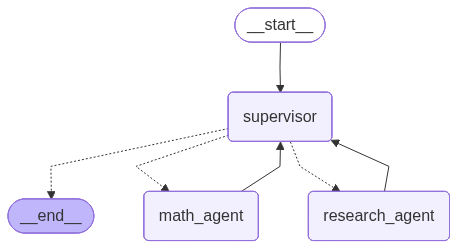

In [ ]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

Let's now run it with a query that requires both agents:

research agent will look up the necessary GDP information
math agent will perform division to find the percentage of NY state GDP, as requested

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Output:

Update from node supervisor:


================================= Tool Message ========

Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message ==========

Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message ========

Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message ========

Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message =========

Name: supervisor

In 2024, the US GDP was $29.18 trillion and New York State's GDP was $2.297 trillion. New York State accounted for approximately 7.87% of the total US GDP in 2024.